# Homework 3
Josh Cohen

In [1]:
import sympy as sym
import numpy as np
%matplotlib notebook
from matplotlib import pyplot as plt
from scipy.integrate import solve_ivp, trapz

In [2]:
#tommy's rk4
def integrate(f,x0,dt):
    k1=dt*np.squeeze(f(x0))
    k2=dt*np.squeeze(f(x0+k1/2.))
    k3=dt*np.squeeze(f(x0+k2/2.))
    k4=dt*np.squeeze(f(x0+k3))
    xnew=x0+(1/6.)*(k1+2.*k2+2.*k3+k4)
    print(xnew)
    return xnew

## Problem 1

**a).** if $\dot{x} = -\sin{(x)}$ & $x(0) = x_0 $, plot $e^-t$ & $x(t)$ on the same graph, what would be a good choice for $x_0$?

In [3]:
t, T, x0, tau = sym.symbols('t T, x_0 tau')
x = sym.Function('x')(t)
xdot = sym.lambdify([t, x], -sym.sin(x))
x0 = 0.8
T = 10
steps = 100
ret = solve_ivp(xdot, (0, 10), [x0], max_step=T/float(steps))

<IPython.core.display.Javascript object>


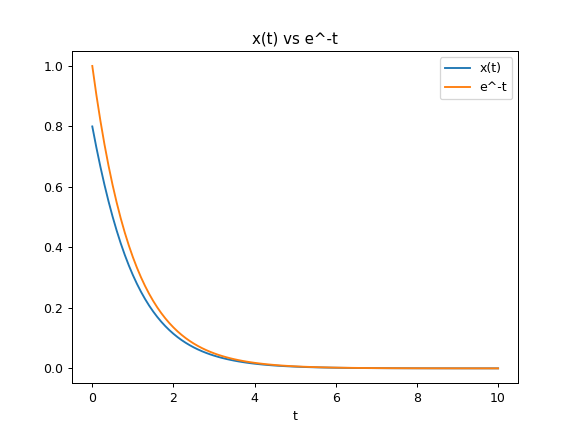

In [4]:
yvals = np.squeeze(ret.y)
xvals = np.squeeze(ret.t)
plt.figure()
plt.plot(xvals,yvals)
plt.plot(xvals, np.exp(-xvals))
plt.legend(["x(t)", "e^-t"])
plt.title("x(t) vs e^-t")
plt.xlabel("t")
plt.show()

**b).** turn in a plot of J vs x0 from 0.9 to 11, where should the minimum be?

In [5]:
l = sym.lambdify([t, x], (sym.exp(-t) - x)**2)
x0_list = np.arange(0.9, 1.1, .002)

J_sum = []

for x0 in x0_list:
    ret = solve_ivp(xdot, (0, 10), [x0], max_step=T/float(steps))
    xvals = ret.y.reshape(-1)
    tvals = ret.t.reshape(-1)
    Jsum = 0
    for (x,t) in zip(xvals,tvals):
        Jsum += l(t, x)

    J_sum.append(Jsum)

J_sum

<IPython.core.display.Javascript object>


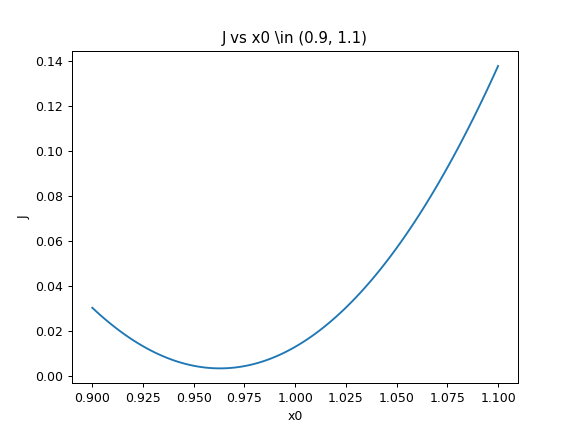

In [6]:
plt.figure()
plt.plot(x0_list, J_sum)

plt.ylabel("J")
plt.xlabel("x0")
plt.title("J vs x0 \in (0.9, 1.1)")

plt.show()

therefore we can roughly expect the minimum to be at ~x0 of 0.96

**c).** Create a function that provides the gradient of J, evaluate at gradient of $x_0 = 1.0$

In [7]:
#need to obtain Dl(x(t)) and integrate to be left with phi(t,0)
t, t0 = sym.symbols('t t_0')
x = sym.Function('x')(t)
phi = sym.Function('phi')(t, 0) 
Dl = sym.lambdify([t, x],((sym.exp(-t)- x) **2).diff(x))

In [8]:
#lets numerically obtain phi
xdot = -sym.sin(x)
A = xdot.diff(x)
# xdot = sym.lambdify([t,x], xdot)
phidot = sym.lambdify([t, [x, phi]], sym.Array([xdot ,A * phi]))
#given: use x0 = 1.0
x0 = 1.0
# ret_x = solve_ivp(xdot, (0,10), [x0], max_step=T/float(steps))
ret_phi = solve_ivp(phidot, (0,10), np.array([x0, 1.0]), max_step=T/float(steps))

In [9]:
tvals = ret_phi.t.reshape(-1)
xvals = ret_phi.y[0,:]
phivals = ret_phi.y[1,:]
integrand = np.multiply(Dl(tvals, xvals) , phivals)

In [10]:
integrand.shape

(102,)

In [11]:
print("The value of the gradient of J evaluated at x0 = 1.0 is:")
trapz(integrand, tvals)

The value of the gradient of J evaluated at x0 = 1.0 is:


0.051869586762385005

**d).** Use gradient descent from previous homework, and the above gradient of J to minimize J with a tolerance of gradJ < $10^{-6}$, start with an IC of $x_0 = 1.0$, what is the optimal value of $x_0$?


In [12]:
#define symbols
t, t0 = sym.symbols('t t_0')
x = sym.Function('x')(t)
phi = sym.Function('phi')(t, 0)
#make computing J easier
Dl = sym.lambdify([t, x],((sym.exp(-t)- x) **2).diff(x))
A = xdot.diff(x)
#devolop update equations
xdot = -sym.sin(x)
phidot = A * phi
#define state variable that we will integrate to get STM
qdot = sym.lambdify([t, [x, phi]], sym.Array([xdot ,A * phi]))
def gradJ(x0):
    #integrate to get xvals, phivals, and time vec
    ret = solve_ivp(qdot, (0,10), np.array([x0, 1.0]), max_step=T/float(steps))
    #seperate values from return
    tvals = ret.t.reshape(-1)
    xvals = ret.y[0,:]
    phivals = ret.y[1,:]
    integrand = np.multiply(Dl(tvals, xvals) , phivals)
    #evaluate the integrand to get the gradient of J!
    ret_val = trapz(integrand, tvals)
    
    return ret_val

In [13]:
def grad_desc(x):
    eps = 10e-6
    grad = gradJ(x)
    num_its = 0
    mag_grad = abs(grad)
    while (mag_grad > eps):
        x_next = x - grad
        grad = gradJ(x_next)
        mag_grad = abs(grad)
        x = x_next
        num_its += 1
    return x, num_its

In [14]:
ans = grad_desc(1)

In [15]:
print("therefore the optimal value of x0 is: {}".format(ans[0]))

therefore the optimal value of x0 is: 0.96001990763378


## Probelm 2

**a).** Plot $J(\tau)$ for $\tau \in (0,0.5)$

In [16]:
tau, t, z = sym.symbols('tau t z')
x0 = sym.Function('x_0')(t)
x1 = sym.Function('x_1')(t)
x = sym.Matrix([x0, x1])
l = sym.lambdify([x], x.norm()**2)
f1 = np.array([[-1, 0],[1, 2]])
f2 = np.array([[1, 1],[1, -2]])

In [17]:
dt = .5/100
tau_list = np.arange(0, 0.55, dt)

In [18]:
display(f1 * x)
print((f1 * x).shape)
sym.Array(f1 * x).shape
display(sym.Array(f1 * x))
display(sym.Array([f1 * x]))

Matrix([
[          -x_0(t)],
[x_0(t) + 2*x_1(t)]])

(2, 1)


[[-x_0(t)], [x_0(t) + 2*x_1(t)]]

[-x_0(t)]

In [19]:
#now with a known x curve we can evaluate J 
J_sum = []
x_init = [1,1]

def zdot(t, x, tau):
    if (t <= tau):
        return np.matmul(f1, x)
    elif(t > tau):
        return np.matmul(f2, x)
        

for tau in tau_list:
    ret = solve_ivp(zdot, (0, 0.5), x_init, max_step = dt, args=(tau,))
    xvals = ret.y
    tvals = ret.t.reshape(-1)
    Jsum = 0
    for xval in xvals.T:
        Jsum += dt * np.linalg.norm(xval, ord=2)**2
    J_sum.append(Jsum)

<IPython.core.display.Javascript object>


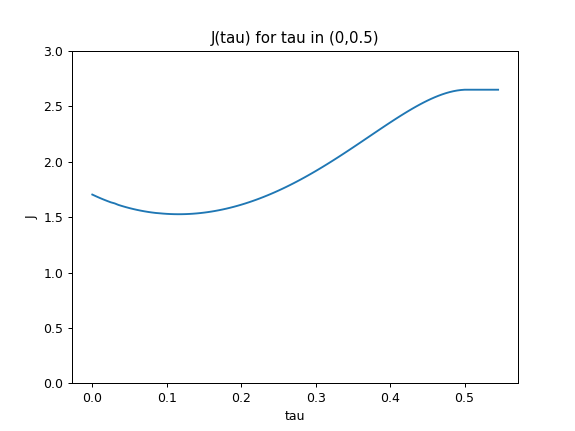

In [20]:
plt.figure()
plt.plot(tau_list, J_sum)
plt.xlabel("tau")
plt.ylabel("J")
plt.title("J(tau) for tau in (0,0.5)")
plt.ylim(0,3)
plt.show()

**b).** find a formula for $\frac{\partial J}{\partial \tau}$ (derivative of J wrt to tau) 

from the notes there are two equations we can use for $\frac{\partial J}{\partial \tau}$ we will choose the one that does not requiore us to resolve for $\frac{\partial x(t)}{\partial \tau}$ for every different $\tau$. This requires we compute the convolution integral, which in turn means we have to solve for $\phi(t,\tau)$, this can be done by integrating the state equation for the convolution integral $\dot{\rho}(s) = -A^T(s) - \frac{\partial l(x(s))^T}{\partial x(s)}$ with $\rho(T) = 0_{Nx1}$ once this is found we can use the equation $\frac{\partial J}{\partial \tau} = \rho(\tau)^T[f_1(x(\tau)) - f_2(x(\tau))]$, the ramifications of fidning this formula will be seen in **c).**

**c).** evaulate derivative at $\tau = 0.25$

In [93]:
#lets first obtain zdot, ode for z = \partial{x} / \partial(tau)
x = sym.Matrix([x0, x1])
f1 = np.array([[-1, 0],[1, 2]])
f2 = np.array([[1, 1],[1, -2]])
t, t0 = sym.symbols('t t_0')
z = sym.Function('z')(t)
phi = sym.Function('phi')(t,t0)
x0 = sym.Function('x_0')(t)
x1 = sym.Function('x_1')(t)
rho0 = sym.Function('rho_0')(t)
rho1 = sym.Function('rho_1')(t)
rho = sym.Matrix([rho0, rho1])
dt = 0.001 
A = (f2 * x).jacobian(x)
l = x.T * x
Dl = l.jacobian(x)

#define ODE that governs rho
# rhodot = sym.lambdify([x, rho] , sym.MatMul(-A.T,rho) - Dl.T)

In [102]:
def rhodot(x, rho):
    return (np.matmul(-f2.T, rho) - 2*x)

#define ODE that governs x
def xdot(t, x, tau):
    if (t <= tau):
        return np.matmul(f1, x)
    elif(t > tau):
        return np.matmul(f2, x)

#ODE that governs q and x
def qdot(t, q, tau):
    x = np.array([q[0], q[1]])
    rho = np.array([q[2], q[3]])
    xnew = xdot(t,x,tau)
    rhonew = rhodot(x, rho)    
    return [xnew[0], xnew[1], rhonew[0], rhonew[1]]

x_init = [1,1]

tau = 0.25

#tricky part here is that we integrate rho backwards and x forwards
ret_x = solve_ivp(xdot, (0,0.5), x_init, max_step = dt,args=(tau,) )
x_fin = ret_x.y[:,-1]
# ret_x_backward = solve_ivp(xdot, (0.5, tau), x_fin, max_step = dt, args=(tau,))
ret_rho = solve_ivp(qdot, (0.5, tau), [x_fin[0],x_fin[1],0,0] ,t_eval = tvals ,args=(tau,))

In [103]:
p_tau = ret_rho.y[2:, -1]
print(p_tau)
x_tau = ret_rho.y[:2, -1]
print(x_tau)
delta_fs = np.matmul(f1, x_tau) - np.matmul(f2, x_tau)
print(delta_fs)
ans = np.matmul(p_tau.T, delta_fs)

print("therefore the gradientn of J with respect to omega at tau = 0.25 is {}".format(ans))

[0.74172351 0.72990206]
[0.7814762  1.93276319]
[-3.49571559  7.73105277]
therefore the gradientn of J with respect to omega at tau = 0.25 is 3.0500569203862042


**d).** Find approximation of the optimal value for $\tau$ using an inital value of 0.25, use gradient descent with an alpha modifying that gradient value

In [106]:
def gradJ(tau):
    x_init = [1,1]
    #tricky part here is that we integrate rho backwards and x forwards
    ret_x = solve_ivp(xdot, (0,0.5), x_init,max_step = dt,args=(tau,) )
    x_fin = ret_x.y[:,-1]
    ret_rho = solve_ivp(qdot, (0.5, tau), [x_fin[0],x_fin[1],0,0] ,max_step = dt,args=(tau,))
    p_tau = np.expand_dims(ret_rho.y[2:, -1],1)
    x_tau = np.expand_dims(ret_rho.y[:2, -1],1)
    delta_fs = np.matmul(f1, x_tau) - np.matmul(f2, x_tau)
    ans = np.matmul(p_tau.T, delta_fs)
    
    return ans[0][0]
    

def grad_desc(tau_last, alpha):
    eps = 10e-2
    grad_last = gradJ(tau_last)
    mag_grad = abs(grad_last)
    print("at tau: {} grad: {}".format(tau_last, grad_last))
    while(mag_grad > eps):
        tau = tau_last - alpha * grad_last
        grad_last = gradJ(tau)
        mag_grad = abs(grad_last)
        tau_last = tau
        print("at tau: {} grad: {}".format(tau, grad_last))
    return tau

In [109]:
opt_tau = grad_desc(0.25, .01)

at tau: 0.25 grad: 3.0621697389187323
at tau: 0.21937830261081268 grad: 2.451864867203301
at tau: 0.19485965393877966 grad: 1.9212478958534995
at tau: 0.17564717498024465 grad: 1.468162232903075
at tau: 0.1609655526512139 grad: 1.1234075370174663
at tau: 0.14973147728103925 grad: 0.8515557444069426
at tau: 0.14121591983696982 grad: 0.6497441524880685
at tau: 0.13471847831208913 grad: 0.48796462207750313
at tau: 0.1298388320913141 grad: 0.38807397141587696
at tau: 0.12595809237715533 grad: 0.27605051762987376
at tau: 0.12319758720085659 grad: 0.20749194657282555
at tau: 0.12112266773512834 grad: 0.15836070835686655
at tau: 0.11953906065155967 grad: 0.12110342881251057
at tau: 0.11832802636343456 grad: 0.0979841733351261


In [112]:
print("therefore the optimal tau is: {:.5f}\n\rthis can also be seen (aprox)in the graph for part a".format(opt_tau))

therefore the optimal tau is: 0.11833
this can also be seen (aprox)in the graph for part a
